In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

Using TensorFlow backend.


In [2]:
# Load dataset from csv file
dataset = pd.read_csv('../historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
# Separate train/test
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [7]:
trainSet.head()

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2015-01-02,A,41.180000,40.560001,39.161114,40.369999,41.310001,1529200
2015-01-05,A,40.320000,39.799999,38.427319,39.700001,40.459999,2041800
2015-01-06,A,39.810001,39.180000,37.828701,39.020000,40.020000,2080600
2015-01-07,A,39.520000,39.700001,38.330769,39.290001,39.810001,3359700
2015-01-08,A,40.240002,40.889999,39.479725,40.180000,40.980000,2116300


In [8]:
# All symbols
symbols = trainSet.ticker.unique()

In [9]:
timesteps = 60
def make_samples(
    data_1,
    data_2,
    s):
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps:i, 0]

        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    x_2 = x_2.reshape(-1,1)
                    # Normalize every samples
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    
                    train_set[s]['x_1'][j].append(sc.transform(x_1))
                    train_set[s]['y'][j].append(sc.transform(y))
                    sc = MinMaxScaler(feature_range=(0,1))
                    train_set[s]['x_2'][j].append(sc.fit_transform(x_2))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True

In [10]:
# Define train_set
train_set = {}
prediction_intervals = [1,3,5,10]
t = 1
for s in symbols:
    train_set.update({s:{
        'x_1':{},
        'x_2':{},
        'y':{},
    }})
    for i in prediction_intervals:
        train_set[s]['x_1'][i] = []
        train_set[s]['x_2'][i] = []
        train_set[s]['y'][i] = []
    
    data_1 = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
    data_2 = trainSet.loc[trainSet['ticker'] == s][['volume']].values
  
    make_samples(
        data_1, 
        data_2, 
        s)
    if t == 2000:
        break
    t += 1

In [11]:
# Define earlystopping callback function
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min', restore_best_weights=True)

In [12]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(2,60), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

# Training

In [43]:
# Training model with two features in train_set
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    
    n_epoch = 100
    x_train = []
    y_train = []
    
    for s in train_set:
        for j in range (0, len(train_set[s]['x_1'][i])):
            x = [
                train_set[s]['x_1'][i][j],
                train_set[s]['x_2'][i][j],
            ]
            x_train.append(x)
        for j in train_set[s]['y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0])
    
    print(X_train.shape, Y_train.shape)
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

(1134125, 2, 60) (1134125,)
Fitting prediction interval 1  model
Train on 793887 samples, validate on 340238 samples
Epoch 1/100
793887/793887 [==============================] - 4s 5us/step - loss: 0.0718 - val_loss: 0.0327
Epoch 2/100
793887/793887 [==============================] - 3s 3us/step - loss: 0.0342 - val_loss: 0.0208
Epoch 3/100
793887/793887 [==============================] - 3s 3us/step - loss: 0.0281 - val_loss: 0.0187
Epoch 4/100
793887/793887 [==============================] - 3s 3us/step - loss: 0.0245 - val_loss: 0.0153
Epoch 5/100
793887/793887 [==============================] - 3s 3us/step - loss: 0.0223 - val_loss: 0.0171
Epoch 6/100
793887/793887 [==============================] - 3s 3us/step - loss: 0.0210 - val_loss: 0.0141
Epoch 7/100
793887/793887 [==============================] - 3s 3us/step - loss: 0.0200 - val_loss: 0.0164
Epoch 8/100
793887/793887 [==============================] - 3s 3us/step - loss: 0.0193 - val_loss: 0.0131
Epoch 9/100
793887/793887 [

783765/783765 [==============================] - 3s 3us/step - loss: 0.0692 - val_loss: 0.0690
Epoch 6/100
783765/783765 [==============================] - 3s 3us/step - loss: 0.0681 - val_loss: 0.0647
Epoch 7/100
783765/783765 [==============================] - 3s 3us/step - loss: 0.0671 - val_loss: 0.0631
Epoch 8/100
783765/783765 [==============================] - 3s 3us/step - loss: 0.0661 - val_loss: 0.0613
Epoch 9/100
783765/783765 [==============================] - 3s 3us/step - loss: 0.0655 - val_loss: 0.0601
Epoch 10/100
783765/783765 [==============================] - 3s 3us/step - loss: 0.0649 - val_loss: 0.0599
Epoch 11/100
783765/783765 [==============================] - 3s 3us/step - loss: 0.0643 - val_loss: 0.0611ETA: 0s -
Epoch 12/100
783765/783765 [==============================] - 3s 3us/step - loss: 0.0639 - val_loss: 0.0625
Epoch 13/100
783765/783765 [==============================] - 3s 3us/step - loss: 0.0634 - val_loss: 0.0593
Epoch 14/100
783765/783765 [========

## Loss Graph

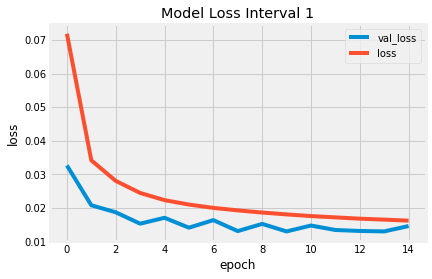

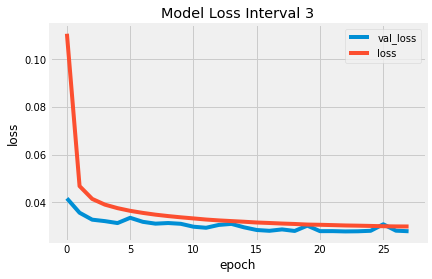

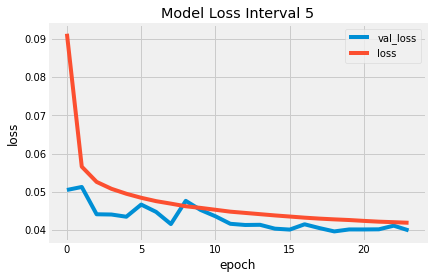

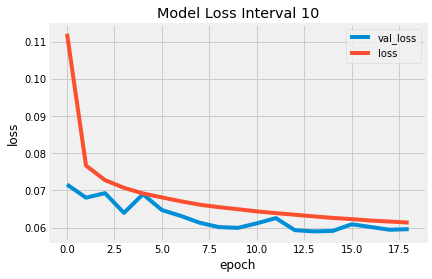

In [44]:
for i in prediction_intervals:
    plt.plot(model_history[i].history['val_loss'])
    plt.plot(model_history[i].history['loss'])
    plt.title('Model Loss Interval {}'.format(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.show()

## Helper functions

In [45]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [46]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Predict with Test Set

In [47]:
# Define test_set
def make_test_data(s):
    scaler = {s:{}}
    test_set = {s:{}}
    test_set.update({s:{
            'x_1':{},
            'x_2':{},
            'y':{},
        }})
    for i in prediction_intervals:
            test_set[s]['x_1'][i] = []
            test_set[s]['x_2'][i] = []
            test_set[s]['y'][i] = []
            scaler[s][i] = []

    data_1 = testSet.loc[testSet['ticker'] == s][['adj_close']].values
    data_2 = testSet.loc[testSet['ticker'] == s][['volume']].values

    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps:i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    x_2 = x_2.reshape(-1,1)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    scaler[s][j].append(sc)
                    test_set[s]['x_1'][j].append(sc.transform(x_1))
                    test_set[s]['y'][j].append(y)
                    sc = MinMaxScaler(feature_range=(0,1))
                    test_set[s]['x_2'][j].append(sc.fit_transform(x_2))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True
                    
    return test_set, scaler

In [48]:
def make_prediction(data, s, scaler):
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    
    for i in prediction_intervals:
        x_test = []
        for j in range (0, len(data[s]['x_1'][i])):
            x = [
                data[s]['x_1'][i][j],
                data[s]['x_2'][i][j],
            ]
            x_test.append(x)

        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
        
        result = model[i].predict(X_test)
        y_pred = []
        for j in range(0,len(result)):
            y = result[j]
            y = y.reshape(-1,1)
            k = scaler[s][i][j].inverse_transform(y)
            y_pred.append(k[0][0])
                    
        y_test = data[s]['y'][i]
        y_true = np.array(y_test)
        y_true = y_true.reshape(y_true.shape[0])
    
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        mse_val[i] = return_mse(y_true, y_pred) 
    return y_true_val, y_pred_val, mse_val

## Predicting test sample

In [49]:
s = 'AAPL'
data, sc = make_test_data(s)
y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)

for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of AAPL inveral 1: 6.5759303754203575
Test Set -> MSE of AAPL inveral 3: 19.433473837126428
Test Set -> MSE of AAPL inveral 5: 34.357849056502246
Test Set -> MSE of AAPL inveral 10: 57.78313633762804


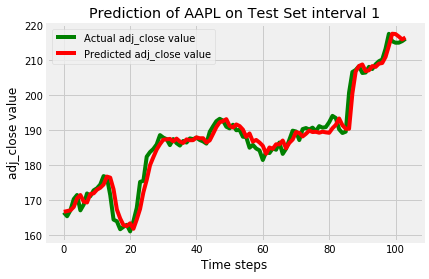

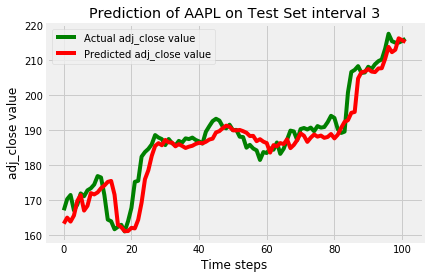

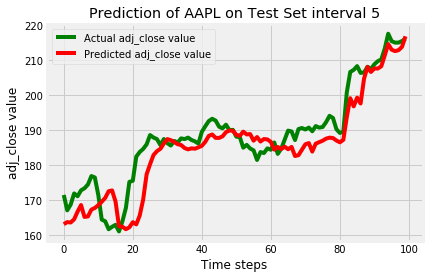

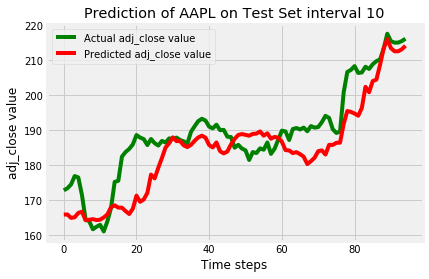

In [50]:
for i in prediction_intervals:
    plotting_graph(y_true_val[i], y_pred_val[i], s, 'Test Set interval {}'.format(i))

# MSE of 5 symbols

In [51]:
test_symbols = ['A', 'ACER', 'MSFT', 'ABC', 'AAPL']

In [52]:
all_mse = {}
for s in test_symbols:
    all_mse[s] = {}
    data, sc = make_test_data(s)
    y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)
    for i in prediction_intervals:
        all_mse[s][i] = mse_val[i]
        all_mse[s][i] = mse_val[i]

In [53]:
all_mse_1 = []
all_mse_3 = []
all_mse_5 = []
all_mse_10 = []
for s in all_mse:
    all_mse_1.append(round(all_mse[s][1], 2))
    all_mse_3.append(round(all_mse[s][3], 2))
    all_mse_5.append(round(all_mse[s][5], 2))
    all_mse_10.append(round(all_mse[s][10], 2))

In [54]:
# MSE of interval 1
all_mse_1

[1.22, 0.87, 1.27, 2.71, 6.58]

In [55]:
# MSE of interval 
all_mse_3

[2.82, 1.87, 2.6, 6.2, 19.43]

In [56]:
# MSE of interval 
all_mse_5

[3.31, 2.72, 3.91, 9.43, 34.36]

In [57]:
# MSE of interval 1
all_mse_10

[4.0, 3.26, 7.34, 17.82, 57.78]